In [ ]:
# Installations
!pip install pandas
!pip install -U scikit-learn

In [ ]:
# Imports
import json
import glob
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Setup
Training df has 290k entries, 212k of which are in English. This is split up into a training set and validation set. The test set is a small set of 8k entries.

In [ ]:
# This is the train df, which will be broken up into a training set and a validation set
df = pd.read_csv("/content/drive/Shareddrives/CIS530 Final Project/datasets/train.csv")
# df = pd.read_csv("/content/drive/MyDrive/Copy of train.csv")

In [ ]:
test_df = pd.read_csv("/content/drive/Shareddrives/CIS530 Final Project/datasets/test.csv")
# test_df = pd.read_csv("/content/drive/MyDrive/Copy of test.csv")

In [ ]:
df

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
290178,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
290179,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
290180,celine dion,sorry for love,Pop,en,Forgive me for the things That I never said to...
290181,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


In [ ]:
df_en = df.loc[df['Language'] == 'en']
df_trun = df_en.sample(frac=1).groupby('Genre').head(1200)
X = df_trun['Lyrics']
Y = df_trun['Genre']
trainX, valX, trainY, valY = train_test_split(X, Y, test_size=0.15)
testX = test_df['Lyrics']
testY = test_df['Genre']

In [ ]:
df_trun['Genre'].info

<bound method Series.info of 38793         Pop
78377         Pop
193830       Rock
66486        Rock
61235        Rock
           ...   
286055    Country
274163    Country
282171    Country
273354    Country
273167    Country
Name: Genre, Length: 12000, dtype: object>

In [ ]:
trainX

218999    Ahhhhhh oooooo\n\nThis is the way\nI always dr...
183912    See your face from afar\nProjecting you into a...
220724    If I could just be anywhere else you know\nI w...
259129    when the silence embraced you did i\nleave you...
7144      Oh, the gentlemen are talking and the midnight...
                                ...                        
277383    I remember trying not to stare the night that ...
285714    Boy you should know that I've got you on my mi...
273716    Lovely Rita meter maid Nothing can come betwee...
151766    And so I saw it\nThe birth of a vampire\nFresh...
271844    Mhm hm let me be a little kinder let me be a l...
Name: Lyrics, Length: 10200, dtype: object

In [ ]:
trainY

218999       Rock
183912      Indie
220724      Metal
259129      Metal
7144         Rock
           ...   
277383    Country
285714    Hip-Hop
273716        R&B
151766      Metal
271844    Country
Name: Genre, Length: 10200, dtype: object

In [ ]:
valX

187768    My love waits for you\nThere's nothing I can d...
212080    Carolina \nGave me Dinah; \nI'm the proudest o...
172861    When the stone is grown too cold to kneel\nIn ...
282171    The only joint my mother burned was on the rur...
29711     Huffman don't take no nonsense\nHe's here to r...
                                ...                        
252773    Hey, domino\nI am stopping you from falling\nO...
282850    Feel I'm on the verge of some greath truth Whe...
283144    Mm Here comes the mailman walking up the stree...
285094    Red wine time on the couch Happy you agreed to...
287336    Where have all the flowers gone long time pass...
Name: Lyrics, Length: 1800, dtype: object

In [ ]:
valY

187768        R&B
212080       Jazz
172861       Folk
282171    Country
29711        Rock
           ...   
252773        Pop
282850      Indie
283144        R&B
285094    Hip-Hop
287336    Country
Name: Genre, Length: 1800, dtype: object

In [ ]:
testX

0       Most folks spend their days daydreaming of fin...
1       Take your cold hands and put them on my face\n...
2       Are you ready it's time for war\nWe'll break d...
3       You ask me why I change the color of my hair\n...
4       Do you believe in magic in a young girl's hear...
                              ...                        
7930    Tuesday night - 7:30\nI hear a voice on the te...
7931    Elite forces cloaked in fur un sensitive to pa...
7932    [Dr. Dre]\nJourney with me\nInto the mind of a...
7933    You can a look a hurricane right in the eye.\n...
7934    Deal not the truth till you find the proof\nAn...
Name: Lyrics, Length: 7935, dtype: object

In [ ]:
testY

0       Hip-Hop
1         Indie
2         Metal
3           Pop
4       Hip-Hop
         ...   
7930       Rock
7931      Metal
7932    Hip-Hop
7933       Rock
7934       Rock
Name: Genre, Length: 7935, dtype: object

# Evaluation Script


In [ ]:
all_genres = set(df['Genre'])
all_genres

{'Country',
 'Electronic',
 'Folk',
 'Hip-Hop',
 'Indie',
 'Jazz',
 'Metal',
 'Pop',
 'R&B',
 'Rock'}

In [ ]:
# Returns percent accuracy, (precision, recall, f1)
def evaluate(pred_labels, labels, genres):
    if len(pred_labels) != len(labels):
        return "Label sizes are no the same"
    tracker = {}
    total_corr = 0
    for x in genres:
        tracker[x] = {'count': 0, 'tp': 0, 'fp': 0, 'fn': 0}
    all_tp = 0
    all_fp = 0
    all_fn = 0
    for pred, actual in zip(pred_labels, labels):
        tracker[actual]['count'] = tracker[actual]['count'] + 1
        if pred == actual:
            tracker[pred]['tp'] = tracker[pred]['tp'] + 1
            all_tp += 1
            total_corr += 1
        else:
            tracker[actual]['fn'] = tracker[actual]['fn'] + 1
            tracker[pred]['fp'] = tracker[pred]['fp'] + 1
            all_fp += 1
            all_fn += 1

    all_stats = {}
    for genre in tracker.keys():
        tp = tracker[genre]['tp']
        fp = tracker[genre]['fp']
        fn = tracker[genre]['fn']
        precision = tp/(tp+fp) if (tp+fp) > 0 else 0
        recall = tp/(tp+fn) if (tp+fn) > 0 else 0
        f1 = precision*recall/(precision+recall) if (precision+recall) > 0 else 0
        all_stats[genre] = {'count': tracker[genre]['count'], 'precision': precision, 'recall': recall, 'f1_score': f1}
    total_precision = all_tp/(all_tp+all_fp) if (all_tp+all_fp) > 0 else 0
    total_recall = all_tp/(all_tp+all_fn) if (all_tp+all_fn) > 0 else 0
    weighted_precision = sum([tracker[genre]['count']*all_stats[genre]['precision'] for genre in tracker.keys()])/len(pred_labels)
    weighted_recall = sum([tracker[genre]['count']*all_stats[genre]['recall'] for genre in tracker.keys()])/len(pred_labels)
    weighted_f1 = sum([tracker[genre]['count']*all_stats[genre]['f1_score'] for genre in tracker.keys()])/len(pred_labels)
    total_stats = {
        'macro_precision': total_precision,
        'macro_recall': total_recall,
        'macro_f1_score': total_precision*total_recall/(total_precision+total_recall)
            if (total_precision+total_recall) > 0 else 0,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1_score': weighted_f1
    }
    return total_corr/len(pred_labels), total_stats, all_stats

In [ ]:
from tabulate import tabulate

def format_evaluation(stats):
    headers = list(all_genres)
    data = []
    for genre in headers:
        data.append([genre] + list(stats[2][genre].values()))
    res = tabulate(data, headers=['Genre', 'Count', 'Precision', 'Recall', 'F1_score'])
    res += '\n\nOverall\n'
    res += 'Accuracy: ' + str(stats[0]) + '\n' + \
        'Weighted Precision: ' + str(stats[1]['weighted_precision']) + '\n' + \
        'Weighted Recall: ' + str(stats[1]['weighted_recall']) + '\n' + \
        'Weighted F1 Score: ' + str(stats[1]['weighted_f1_score']) + '\n' + \
        'Macro Precision: ' + str(stats[1]['macro_precision']) + '\n' + \
        'Macro Recall: ' + str(stats[1]['macro_recall']) + '\n' + \
        'Macro F1 Score: ' + str(stats[1]['macro_f1_score'])
    return res

# Simple Baseline
Majority class classifier. The simple baseline model will always output "Rock" because we encounter "Rock" 43% of the time in the training set.

In [ ]:
genre_popularity = df_en['Genre'].value_counts()
genre_popularity

Rock          107145
Pop            86298
Metal          19133
Jazz           13314
Folk            8169
Indie           7240
R&B             2765
Hip-Hop         2238
Electronic      2005
Country         1890
Name: Genre, dtype: int64

In [ ]:
sorted_genres = genre_popularity.index.values.tolist()
sorted_genres

['Rock',
 'Pop',
 'Metal',
 'Jazz',
 'Folk',
 'Indie',
 'R&B',
 'Hip-Hop',
 'Electronic',
 'Country']

In [ ]:
genres_popularity_count = genre_popularity.to_list()
genres_popularity_count

[107145, 86298, 19133, 13314, 8169, 7240, 2765, 2238, 2005, 1890]

([<matplotlib.patches.Wedge at 0x7f8552a38fd0>,
 [Text(0.51635005130364, 2.251551159649438, 'Rock'),
  Text(-1.8628167949274688, -1.366021079096569, 'Pop'),
  Text(0.8692085295014663, -2.140228149577026, 'Metal'),
  Text(1.6461083667965148, -1.6206255720438674, 'Jazz'),
  Text(2.0184632220222345, -1.1233459936028716, 'Folk'),
  Text(2.1967942881815303, -0.7142792559027641, 'Indie'),
  Text(2.268979167576007, -0.4333976662443989, 'R&B'),
  Text(2.291711695877655, -0.2900991261234101, 'Hip-Hop'),
  Text(2.3039083453470406, -0.16764944449733296, 'Electronic'),
  Text(2.3093495306353353, -0.054815557594152894, 'Country')],
 [Text(0.28164548252925814, 1.2281188143542388, '42.8%'),
  Text(-1.0160818881422555, -0.7451024067799465, '34.5%'),
  Text(0.47411374336443607, -1.1673971724965595, '7.6%'),
  Text(0.897877290979917, -0.8839775847512003, '5.3%'),
  Text(1.100979939284855, -0.6127341783288389, '3.3%'),
  Text(1.198251429917198, -0.38960686685605306, '2.9%'),
  Text(1.2376250004960037, -0

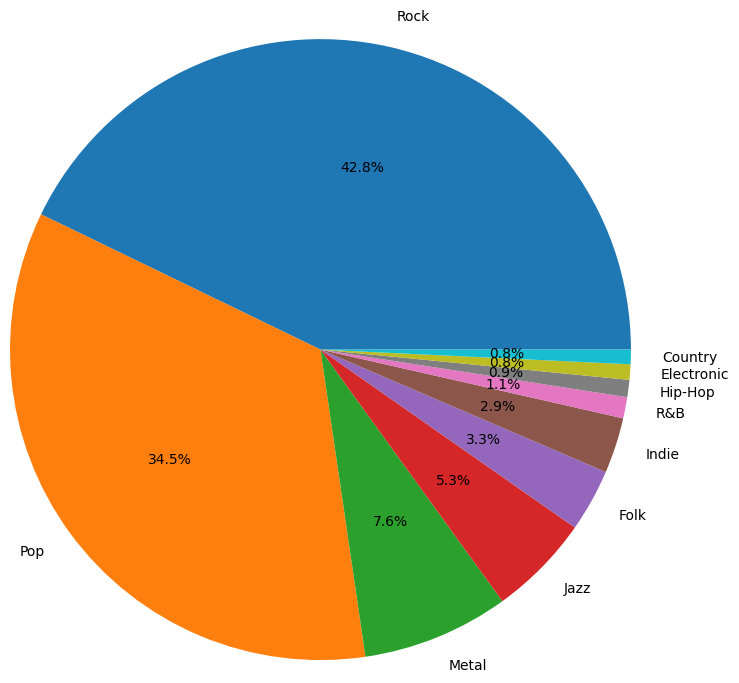

In [ ]:
fig, ax = plt.subplots()
ax.pie(genres_popularity_count, labels=sorted_genres, autopct='%1.1f%%', radius=2.1)

## Predicting the majority class

In [ ]:
# Find the majority class
majority_class = sorted_genres[0]
majority_class

'Rock'

In [ ]:
# Predict the majority class for all instances

def all_majority(input):
    y_pred = [majority_class] * len(input)
    return y_pred

In [ ]:
# Training accuracy
y_pred = all_majority(trainX)
evaluation = evaluate(y_pred, trainY, all_genres)
print(format_evaluation(evaluation))

Genre         Count    Precision    Recall    F1_score
----------  -------  -----------  --------  ----------
Electronic     1024     0                0   0
Metal          1032     0                0   0
Hip-Hop        1007     0                0   0
Indie          1005     0                0   0
Jazz           1007     0                0   0
Folk           1030     0                0   0
Pop            1026     0                0   0
Rock           1033     0.101275         1   0.0919612
R&B            1018     0                0   0
Country        1018     0                0   0

Overall
Accuracy: 0.10127450980392157
Weighted Precision: 0.010256526336024606
Weighted Recall: 0.10127450980392157
Weighted F1 Score: 0.009313324012058307
Macro Precision: 0.10127450980392157
Macro Recall: 0.10127450980392157
Macro F1 Score: 0.05063725490196078


In [ ]:
# Validation accuracy
y_pred = all_majority(valX)
evaluation = evaluate(y_pred, valY, all_genres)
print(format_evaluation(evaluation))

Genre         Count    Precision    Recall    F1_score
----------  -------  -----------  --------  ----------
Electronic      176    0                 0   0
Metal           168    0                 0   0
Hip-Hop         193    0                 0   0
Indie           195    0                 0   0
Jazz            193    0                 0   0
Folk            170    0                 0   0
Pop             174    0                 0   0
Rock            167    0.0927778         1   0.0849009
R&B             182    0                 0   0
Country         182    0                 0   0

Overall
Accuracy: 0.09277777777777778
Weighted Precision: 0.008607716049382716
Weighted Recall: 0.09277777777777778
Weighted F1 Score: 0.007876913517482912
Macro Precision: 0.09277777777777778
Macro Recall: 0.09277777777777778
Macro F1 Score: 0.04638888888888889


In [ ]:
# Test accuracy
y_pred = all_majority(testX)
evaluation = evaluate(y_pred, testY, all_genres)
print(format_evaluation(evaluation))

Genre         Count    Precision    Recall    F1_score
----------  -------  -----------  --------  ----------
Electronic      660     0                0    0
Metal           810     0                0    0
Hip-Hop         960     0                0    0
Indie           510     0                0    0
Jazz            660     0                0    0
Folk            495     0                0    0
Pop            1110     0                0    0
Rock           1410     0.177694         1    0.150883
R&B             510     0                0    0
Country         810     0                0    0

Overall
Accuracy: 0.1776937618147448
Weighted Precision: 0.031575072987875256
Weighted Recall: 0.1776937618147448
Weighted F1 Score: 0.026810936774616392
Macro Precision: 0.1776937618147448
Macro Recall: 0.1776937618147448
Macro F1 Score: 0.08884688090737239


# Transformer-based Model (with TF-IDF)

In [ ]:
!pip install transformers
!pip install torch
!pip install tqdm

In [ ]:
import torch
print(torch.__version__)

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import AdamW
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, normalize
import torch.nn as nn

# using distiled bert
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

2.1.0+cu121


### distillBERT

In [ ]:
# pre-trained BERT (vanilla)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 10
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
tfidf_vectorizer = TfidfVectorizer()


train_tfidf_features = tfidf_vectorizer.fit_transform(trainX).toarray()
val_tfidf_features = tfidf_vectorizer.transform(valX).toarray()

scaler = StandardScaler()
train_tfidf_features = scaler.fit_transform(train_tfidf_features)
val_tfidf_features = scaler.transform(val_tfidf_features)

train_tfidf_features = normalize(train_tfidf_features, norm='l2')
val_tfidf_features = normalize(val_tfidf_features, norm='l2')

# convert TF-IDF features to tensors
train_tfidf_features = torch.tensor(train_tfidf_features, dtype=torch.float32)
val_tfidf_features = torch.tensor(val_tfidf_features, dtype=torch.float32)

# convert genres to numerical labels
genre_to_id = {genre: i for i, genre in enumerate(sorted(all_genres))}
id_to_genre = {i: genre for genre, i in genre_to_id.items()}
train_labels = torch.tensor([genre_to_id[genre] for genre in trainY])
val_labels = torch.tensor([genre_to_id[genre] for genre in valY])

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def batch_tokenize(tokenizer, texts, tfidf_features, labels, batch_size=100):
    """ Tokenize texts in smaller batches """
    tokenized_batches = {
        'input_ids': [],
        'attention_mask': [],
        'tfidf_features': [],
        'labels': []
    }
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_tfidf = tfidf_features[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        # Tokenize text
        tokenized = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")

        # Convert TF-IDF features to tensors
        batch_tfidf = torch.tensor(batch_tfidf, dtype=torch.float32)

        # Append to tokenized_batches
        tokenized_batches['input_ids'].append(tokenized['input_ids'])
        tokenized_batches['attention_mask'].append(tokenized['attention_mask'])
        tokenized_batches['tfidf_features'].append(batch_tfidf)
        tokenized_batches['labels'].append(batch_labels)

    # concatenate
    tokenized_batches['input_ids'] = torch.cat(tokenized_batches['input_ids'], dim=0)
    tokenized_batches['attention_mask'] = torch.cat(tokenized_batches['attention_mask'], dim=0)
    tokenized_batches['tfidf_features'] = torch.cat(tokenized_batches['tfidf_features'], dim=0)
    tokenized_batches['labels'] = torch.cat(tokenized_batches['labels'], dim=0)

    return tokenized_batches

In [ ]:
# tokenizing train data
train_data_tokens = batch_tokenize(
    tokenizer,
    trainX.tolist(),
    train_tfidf_features,
    train_labels,
    batch_size=100
)

# tokenize validation data
val_data_tokens = batch_tokenize(
    tokenizer,
    valX.tolist(),
    val_tfidf_features,
    val_labels,
    batch_size=100
)


# dataloaders
batch_size = 4
train_data = TensorDataset(train_data_tokens['input_ids'], train_data_tokens['attention_mask'], train_tfidf_features, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(val_data_tokens['input_ids'], val_data_tokens['attention_mask'], val_tfidf_features, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# saving checkpoints
import os

def save_checkpoint(model, optimizer, epoch, batch, file_path):
    checkpoint = {
        'epoch': epoch,
        'batch': batch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, file_path)

In [ ]:
# loading checkpoints
def load_checkpoint(model, optimizer, file_path="checkpoint.pth"):
    if os.path.isfile(file_path):
        print(f"Loading checkpoint '{file_path}'")
        checkpoint = torch.load(file_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        batch = checkpoint.get('batch', 0)
        return epoch,batch
    else:
        print(f"No checkpoint found at '{file_path}'")
        return 0,0

# Load checkpoint if available
start_epoch, start_batch = load_checkpoint(model, optimizer, file_path="checkpoint.pth")

In [ ]:
print(model)

In [ ]:
# Ensure the model is on the right device
model.to(device)

# training loop
model.train()
print("start training..")

checkpoint_interval = 5000

for epoch in range(start_epoch, 3):  # Number of epochs
    total_loss = 0
    print(f"Epoch {epoch + 1}/{3}")
    for step, batch in enumerate(tqdm(train_dataloader)):
        b_input_ids, b_input_mask, b_tfidf_features, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Concatenate pooled_output with TF-IDF features
        combined_features = torch.cat((logits, b_tfidf_features), dim=1)

        loss = criterion(combined_features, b_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Print loss every 5000 batches
        if (step % 5000) == 0 and not step == 0:
            print(f"Batch {step} of {len(train_dataloader)}. Loss: {loss.item()}")

        # Save checkpoint periodically
        if (step % checkpoint_interval) == 0:
            checkpoint_path = f"checkpoint_epoch_{epoch}_batch_{step}.pth"
            save_checkpoint(model, optimizer, epoch, step, file_path=checkpoint_path)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

    # quick eval at the end of each epoch
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_tfidf_features, b_labels = tuple(t.to(device) for t in batch)

            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

            # Concatenate pooled_output with TF-IDF features
            combined_features = torch.cat((logits, b_tfidf_features), dim=1)

            predictions = torch.argmax(combined_features, dim=1)
            correct += (predictions == b_labels).sum().item()
            total += b_labels.size(0)

        print(f"Validation Accuracy after epoch {epoch + 1}: {correct / total:.4f}")

    # save checkpoint at the end of each epoch
    save_checkpoint(model, optimizer, epoch, step, file_path=f"checkpoint_epoch_{epoch}.pth")
    # reset to train
    model.train()

print("Training complete.")


In [ ]:
# evaluation
model.eval()
val_predictions = []
val_true_labels = []
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_tfidf_features, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits

    concatenated_features = torch.cat([logits, b_tfidf_features], dim=1)

    predictions = torch.argmax(concatenated_features, dim=1)
    val_predictions.extend(predictions.cpu().numpy())
    val_true_labels.extend(b_labels.cpu().numpy())

val_acc = accuracy_score(val_true_labels, val_predictions)
print(f"Validation Accuracy: {val_acc}")
val_pred_genres = [id_to_genre[label] for label in val_predictions]
val_true_genres = [id_to_genre[label] for label in val_true_labels]

evaluation = evaluate(val_pred_genres, val_true_genres, sorted(all_genres))
print(format_evaluation(evaluation))

In [ ]:
# Test
test_tfidf_features = tfidf_vectorizer.transform(testX).toarray()

# normalize features
test_tfidf_features = scaler.transform(test_tfidf_features)
test_tfidf_features = normalize(test_tfidf_features, norm='l2')

test_tfidf_features = torch.tensor(test_tfidf_features, dtype=torch.float32)

# Test
# add test dataloader
test_data_tokens = tokenizer(
    testX.tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

test_labels = torch.tensor([genre_to_id[genre] for genre in testY])

test_data = TensorDataset(test_data_tokens['input_ids'], test_data_tokens['attention_mask'], test_tfidf_features, test_labels)

test_batch_size = 16
test_dataloader = DataLoader(test_data, batch_size=test_batch_size)

# Evaluation on test set
model.eval()  # Set the model to evaluation mode
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_tfidf_features, b_labels = tuple(t.to(device) for t in batch)

        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        concatenated_features = torch.cat([logits, b_tfidf_features], dim=1)

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(b_labels.cpu().numpy())

test_acc = accuracy_score(test_true_labels, test_predictions)
print(f"Test Accuracy: {test_acc}")

test_pred_genres = [id_to_genre[label] for label in test_predictions]
test_true_genres = [id_to_genre[label] for label in test_true_labels]
evaluation = evaluate(test_pred_genres, test_true_genres, sorted(all_genres))
print(format_evaluation(evaluation))

## BERT

In [ ]:
# pre-trained BERT (vanilla)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(trainY)))

# Convert genres to numerical labels
genre_to_id = {genre: i for i, genre in enumerate(sorted(all_genres))}
id_to_genre = {i: genre for genre, i in genre_to_id.items()}
train_labels = torch.tensor([genre_to_id[genre] for genre in trainY])
val_labels = torch.tensor([genre_to_id[genre] for genre in valY])

In [ ]:
# # tokenizing train data
train_data_tokens = batch_tokenize(
    tokenizer,
    trainX,
    batch_size=100
)

# tokenize validation data
val_data_tokens = batch_tokenize(
    tokenizer,
    valX,
    batch_size=100
)

# dataloaders
batch_size = 4
train_data = TensorDataset(train_data_tokens['input_ids'], train_data_tokens['attention_mask'], train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(val_data_tokens['input_ids'], val_data_tokens['attention_mask'], val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
# optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# saving checkpoints
import os

def save_checkpoint(model, optimizer, epoch, batch, file_path):
    checkpoint = {
        'epoch': epoch,
        'batch': batch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, file_path)

# loading checkpoints
def load_checkpoint(model, optimizer, file_path="checkpoint.pth"):
    if os.path.isfile(file_path):
        print(f"Loading checkpoint '{file_path}'")
        checkpoint = torch.load(file_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        batch = checkpoint.get('batch', 0)
        return epoch,batch
    else:
        print(f"No checkpoint found at '{file_path}'")
        return 0,0

# Load checkpoint if available
start_epoch, start_batch = load_checkpoint(model, optimizer, file_path="checkpoint.pth")

In [ ]:
# Ensure the model is on the right device
model.to(device)

# training loop
model.train()
print("start training..")

checkpoint_interval = 5000

for epoch in range(start_epoch,3):  # Number of epochs
    total_loss = 0
    print(f"Epoch {epoch+1}/{3}")
    for step, batch in enumerate(tqdm(train_dataloader)):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Print loss every 5000 batches
        if (step % 5000) == 0 and not step == 0:
            print(f"Batch {step} of {len(train_dataloader)}. Loss: {loss.item()}")

        # Save checkpoint periodically
        if (step % checkpoint_interval) == 0:
            checkpoint_path = f"checkpoint_epoch_{epoch}_batch_{step}.pth"
            save_checkpoint(model, optimizer, epoch, step, file_path=checkpoint_path)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

    # quick eval at the end of each epoch
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == b_labels).sum().item()
            total += b_labels.size(0)

        print(f"Validation Accuracy after epoch {epoch+1}: {correct / total:.4f}")

    # save checkpoint at end of epoch
    save_checkpoint(model, optimizer, epoch, step, file_path=f"checkpoint_epoch_{epoch}.pth")
    # reset to train
    model.train()

print("Training complete.")

In [ ]:
# evaluation
model.eval()
val_predictions = []
val_true_labels = []
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    val_predictions.extend(np.argmax(logits, axis=1).flatten())
    val_true_labels.extend(label_ids.flatten())

val_acc = accuracy_score(val_true_labels, val_predictions)
print(f"Validation Accuracy: {val_acc}")

val_pred_genres = [id_to_genre[label] for label in val_predictions]
val_true_genres = [id_to_genre[label] for label in val_true_labels]

evaluation = evaluate(val_pred_genres, val_true_labels, sorted(all_genres))
print(format_evaluation(evaluation))

In [ ]:
# Test
# add test dataloader
test_data_tokens = tokenizer(
    testX.tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

test_labels = torch.tensor([genre_to_id[genre] for genre in testY])

test_data = TensorDataset(test_data_tokens['input_ids'], test_data_tokens['attention_mask'], test_labels)


test_batch_size = 16
test_dataloader = DataLoader(test_data, batch_size=test_batch_size)


# Evaluation on test set
model.eval()  # Set the model to evaluation mode
test_predictions = []
test_true_labels = []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    test_predictions.extend(np.argmax(logits, axis=1).flatten())
    test_true_labels.extend(label_ids.flatten())

test_acc = accuracy_score(test_true_labels, test_predictions)
print(f"Test Accuracy: {test_acc}")

test_pred_genres = [id_to_genre[label] for label in test_predictions]
test_true_genres = [id_to_genre[label] for label in test_true_labels]
evaluation = evaluate(test_pred_genres, test_true_labels, sorted(all_genres))
print(format_evaluation(evaluation))

## RoBERTa

For milestone 3, we added tf-idf as a feature and accoridngly updated the preprocessing steps, batch_tokenize function, tokenization parameters and training and test loop. To run this code, just run the two cells below Strong Baseline downloading the necessary imports and then run all cells underneath this markdown cell.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(set(trainY)))
tfidf_vectorizer = TfidfVectorizer()

train_tfidf_features = tfidf_vectorizer.fit_transform(trainX).toarray()
val_tfidf_features = tfidf_vectorizer.transform(valX).toarray()

scaler = StandardScaler()
train_tfidf_features = scaler.fit_transform(train_tfidf_features)
val_tfidf_features = scaler.transform(val_tfidf_features)

train_tfidf_features = normalize(train_tfidf_features, norm='l2')
val_tfidf_features = normalize(val_tfidf_features, norm='l2')

# convert TF-IDF features to tensors
train_tfidf_features = torch.tensor(train_tfidf_features, dtype=torch.float32)
val_tfidf_features = torch.tensor(val_tfidf_features, dtype=torch.float32)

# convert genres to numerical labels
genre_to_id = {genre: i for i, genre in enumerate(sorted(all_genres))}
id_to_genre = {i: genre for genre, i in genre_to_id.items()}
train_labels = torch.tensor([genre_to_id[genre] for genre in trainY])
val_labels = torch.tensor([genre_to_id[genre] for genre in valY])

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def batch_tokenize(tokenizer, texts, tfidf_features, labels, batch_size=100):
    """ Tokenize texts in smaller batches """
    tokenized_batches = {
        'input_ids': [],
        'attention_mask': [],
        'tfidf_features': [],
        'labels': []
    }
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_tfidf = tfidf_features[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        # Tokenize text
        tokenized = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")

        # Convert TF-IDF features to tensors
        batch_tfidf = torch.tensor(batch_tfidf, dtype=torch.float32)

        # Append to tokenized_batches
        tokenized_batches['input_ids'].append(tokenized['input_ids'])
        tokenized_batches['attention_mask'].append(tokenized['attention_mask'])
        tokenized_batches['tfidf_features'].append(batch_tfidf)
        tokenized_batches['labels'].append(batch_labels)

    # concatenate
    tokenized_batches['input_ids'] = torch.cat(tokenized_batches['input_ids'], dim=0)
    tokenized_batches['attention_mask'] = torch.cat(tokenized_batches['attention_mask'], dim=0)
    tokenized_batches['tfidf_features'] = torch.cat(tokenized_batches['tfidf_features'], dim=0)
    tokenized_batches['labels'] = torch.cat(tokenized_batches['labels'], dim=0)

    return tokenized_batches

In [ ]:
# tokenizing train data
train_data_tokens = batch_tokenize(
    tokenizer,
    trainX.tolist(),
    train_tfidf_features,
    train_labels,
    batch_size=100
)

# tokenize validation data
val_data_tokens = batch_tokenize(
    tokenizer,
    valX.tolist(),
    val_tfidf_features,
    val_labels,
    batch_size=100
)


# dataloaders
batch_size = 4
train_data = TensorDataset(train_data_tokens['input_ids'], train_data_tokens['attention_mask'], train_tfidf_features, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(val_data_tokens['input_ids'], val_data_tokens['attention_mask'], val_tfidf_features, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# saving checkpoints
import os

def save_checkpoint(model, optimizer, epoch, batch, file_path):
    checkpoint = {
        'epoch': epoch,
        'batch': batch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, file_path)

# loading checkpoints
def load_checkpoint(model, optimizer, file_path="checkpoint.pth"):
    if os.path.isfile(file_path):
        print(f"Loading checkpoint '{file_path}'")
        checkpoint = torch.load(file_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        batch = checkpoint.get('batch', 0)
        return epoch,batch
    else:
        print(f"No checkpoint found at '{file_path}'")
        return 0,0

# Load checkpoint if available
start_epoch, start_batch = load_checkpoint(model, optimizer, file_path="checkpoint.pth")

No checkpoint found at 'checkpoint.pth'


In [ ]:
# Ensure the model is on the right device
model.to(device)

# training loop
model.train()
print("start training..")

checkpoint_interval = 5000

for epoch in range(start_epoch, 3):  # Number of epochs
    total_loss = 0
    print(f"Epoch {epoch + 1}/{3}")
    for step, batch in enumerate(tqdm(train_dataloader)):
        b_input_ids, b_input_mask, b_tfidf_features, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Concatenate pooled_output with TF-IDF features
        combined_features = torch.cat((logits, b_tfidf_features), dim=1)

        loss = criterion(combined_features, b_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Print loss every 5000 batches
        if (step % 5000) == 0 and not step == 0:
            print(f"Batch {step} of {len(train_dataloader)}. Loss: {loss.item()}")

        # Save checkpoint periodically
        if (step % checkpoint_interval) == 0:
            checkpoint_path = f"checkpoint_epoch_{epoch}_batch_{step}.pth"
            save_checkpoint(model, optimizer, epoch, step, file_path=checkpoint_path)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

    # quick eval at the end of each epoch
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_tfidf_features, b_labels = tuple(t.to(device) for t in batch)

            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

            # Concatenate pooled_output with TF-IDF features
            combined_features = torch.cat((logits, b_tfidf_features), dim=1)

            predictions = torch.argmax(combined_features, dim=1)
            correct += (predictions == b_labels).sum().item()
            total += b_labels.size(0)

        print(f"Validation Accuracy after epoch {epoch + 1}: {correct / total:.4f}")

    # save checkpoint at the end of each epoch
    save_checkpoint(model, optimizer, epoch, step, file_path=f"checkpoint_epoch_{epoch}.pth")
    # reset to train
    model.train()

print("Training complete.")

start training..
Epoch 1/3


100%|██████████| 2550/2550 [17:08<00:00,  2.48it/s]


Average training loss: 2.771001888198011
Validation Accuracy after epoch 1: 0.4517
Epoch 2/3


100%|██████████| 2550/2550 [17:04<00:00,  2.49it/s]


Average training loss: 1.4738494201910262
Validation Accuracy after epoch 2: 0.5122
Epoch 3/3


100%|██████████| 2550/2550 [16:57<00:00,  2.51it/s]


Average training loss: 1.2341677723854196
Validation Accuracy after epoch 3: 0.5333
Training complete.


In [ ]:
# evaluation
model.eval()
val_predictions = []
val_true_labels = []
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_tfidf_features, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits

    concatenated_features = torch.cat([logits, b_tfidf_features], dim=1)

    predictions = torch.argmax(concatenated_features, dim=1)
    val_predictions.extend(predictions.cpu().numpy())
    val_true_labels.extend(b_labels.cpu().numpy())

val_acc = accuracy_score(val_true_labels, val_predictions)
print(f"Validation Accuracy: {val_acc}")
val_pred_genres = [id_to_genre[label] for label in val_predictions]
val_true_genres = [id_to_genre[label] for label in val_true_labels]

evaluation = evaluate(val_pred_genres, val_true_genres, sorted(all_genres))
print(format_evaluation(evaluation))

Validation Accuracy: 0.5333333333333333
Genre         Count    Precision    Recall    F1_score
----------  -------  -----------  --------  ----------
Indie           173     0.28754   0.520231    0.185185
Rock            183     0.365672  0.26776     0.154574
Metal           175     0.676259  0.537143    0.299363
Folk            190     0.449074  0.510526    0.238916
Hip-Hop         162     0.934783  0.796296    0.43
Pop             191     0.669565  0.403141    0.251634
Jazz            170     0.766355  0.482353    0.296029
Country         188     0.75      0.638298    0.344828
Electronic      180     0.473684  0.7         0.282511
R&B             188     0.45283   0.510638    0.24

Overall
Accuracy: 0.5333333333333333
Weighted Precision: 0.5785161464095416
Weighted Recall: 0.5333333333333333
Weighted F1 Score: 0.2705296290997602
Macro Precision: 0.5333333333333333
Macro Recall: 0.5333333333333333
Macro F1 Score: 0.26666666666666666


In [ ]:
# Test
test_tfidf_features = tfidf_vectorizer.transform(testX).toarray()

# normalize features
test_tfidf_features = scaler.transform(test_tfidf_features)
test_tfidf_features = normalize(test_tfidf_features, norm='l2')

test_tfidf_features = torch.tensor(test_tfidf_features, dtype=torch.float32)

# Test
# add test dataloader
test_data_tokens = tokenizer(
    testX.tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

test_labels = torch.tensor([genre_to_id[genre] for genre in testY])

test_data = TensorDataset(test_data_tokens['input_ids'], test_data_tokens['attention_mask'], test_tfidf_features, test_labels)

test_batch_size = 16
test_dataloader = DataLoader(test_data, batch_size=test_batch_size)

# Evaluation on test set
model.eval()  # Set the model to evaluation mode
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_tfidf_features, b_labels = tuple(t.to(device) for t in batch)

        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        concatenated_features = torch.cat([logits, b_tfidf_features], dim=1)

        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(b_labels.cpu().numpy())

test_acc = accuracy_score(test_true_labels, test_predictions)
print(f"Test Accuracy: {test_acc}")

test_pred_genres = [id_to_genre[label] for label in test_predictions]
test_true_genres = [id_to_genre[label] for label in test_true_labels]
evaluation = evaluate(test_pred_genres, test_true_genres, sorted(all_genres))
print(format_evaluation(evaluation))

Test Accuracy: 0.2375551354757404
Genre         Count    Precision      Recall    F1_score
----------  -------  -----------  ----------  ----------
Indie           510    0.105764   0.392157    0.0832986
Rock           1410    0.212732   0.374468    0.135663
Metal           810    0.518182   0.703704    0.298429
Folk            495    0.176117   0.414141    0.123568
Hip-Hop         960    1          0.00416667  0.00414938
Pop            1110    0.22023    0.154955    0.0909572
Jazz            660    0.5        0.287879    0.182692
Country         810    0          0           0
Electronic      660    0.215686   0.0166667   0.0154712
R&B             510    0.0657895  0.00980392  0.00853242

Overall
Accuracy: 0.2375551354757404
Weighted Precision: 0.3240274571807125
Weighted Recall: 0.2375551354757404
Weighted F1 Score: 0.09788864337050888
Macro Precision: 0.2375551354757404
Macro Recall: 0.2375551354757404
Macro F1 Score: 0.1187775677378702
